### Loading and installing packages

In [356]:
'''
Installing Twarc package and configuration for authentication
pip install --upgrade twarc
!twarc2 configure
Keyword here for searching tweets is Russia 
Including only enlgish based tweets without retweets and replies
!twarc2 search "russia lang:en -is:retweet -is:reply" --limit 10000 results.jsonl
'''
import pandas as pd
pd.set_option('display.max_seq_items', None)
import numpy as np
from bertopic import BERTopic
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import nltk
nltk.download('wordnet')
#Installing BERTopic package
#conda install -c conda-forge hdbscan
#pip install bertopic
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#pip install wordcloud
#pip install plotnine   
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elee0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elee0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elee0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\elee0\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Mining 10,000 tweets (#Russia, #Ukraine at 03-08-20)

In [357]:
#Reading JSON files mined from Twarc
rusdf = pd.read_json('russia1.jsonl',lines=True)
ukrdf = pd.read_json('ukraine1.jsonl',lines=True)

In [358]:
tweet_rusdf = rusdf['text']
tweet_rusdf = tweet_rusdf.to_frame(name='original')
tweet_rusdf.head() 

,original
0,Leave Russia now! https://t.co/0zyh0AU3xT
1,"Days ago, Russia published docs showing Ukrain..."
2,This is true 😌#RussianUkrainianWar\nOne thing ...
3,The occupiers do not take care of their equipm...
4,MODIJI CAN U SEE HOW POOR THE WEAPONS WE HAVE ...


In [359]:
tweet_ukrdf = ukrdf['text']
tweet_ukrdf = tweet_ukrdf.to_frame(name='original')
tweet_ukrdf.head() 

,original
0,Home Secretary announced welcome changes to Uk...
1,The inhuman treatment of Africans in Ukraine r...
2,#Ukraine officials and #Zelensky are following...
3,Western Media is turning head over heal on the...
4,The Week That Awoke the World https://t.co/YOf...


## Tweet cleaning and preprocessing

In [360]:
#Function for cleaning tweets
def data_cleaning(tweets):
    #Lowercasing the tweets
    clean = tweets.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    #Removing contractions
    clean = clean.str.replace("'",' ')
    
    #Remove hashtags and mentions
    clean = clean.str.replace("@[A-Za-z0-9_]+",' ')
    clean = clean.str.replace("#[A-Za-z0-9_]+",' ')
    
    #Removing links
    clean = clean.str.replace(r'http\S+',' ')
    
    #Removing punctuations and numbers
    clean = clean.str.replace('[()!?]',' ')
    clean = clean.str.replace('\[.*?\]',' ')
    clean = clean.str.replace('[0-9]',' ')
    
    #Filtering non-alphanumeric
    clean = clean.str.replace("[^a-z0-9]",' ')
    
    # Removing stopwords
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    clean = clean.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #Dropping duplicated tweets
    clean = clean.drop_duplicates()
       
    return clean

In [361]:
tweet_rusdf['cleaned_data'] = data_cleaning(tweet_rusdf['original'])

In [362]:
# Dropping origiinal tweets based on cleaned tweets
tweet_rusdf = tweet_rusdf.drop(tweet_rusdf[tweet_rusdf['cleaned_data'].isnull()].index)
# Re-indexing
tweet_rusdf = tweet_rusdf.reset_index(drop=True)

In [363]:
tweet_rusdf.describe()

,original,cleaned_data
count,8258,8258
unique,8258,8258
top,US: *places sanctions*\nRussia: https://t.co/F...,
freq,1,1


In [364]:
tweet_rusdf.head()

,original,cleaned_data
0,Leave Russia now! https://t.co/0zyh0AU3xT,leave russia
1,"Days ago, Russia published docs showing Ukrain...",days ago russia published docs showing ukraine...
2,This is true 😌#RussianUkrainianWar\nOne thing ...,true one thing understood became puppet poor n...
3,The occupiers do not take care of their equipm...,occupiers take care equipment
4,MODIJI CAN U SEE HOW POOR THE WEAPONS WE HAVE ...,modiji u see poor weapons received russia modi...


In [365]:
tweet_ukrdf['cleaned_data'] = data_cleaning(tweet_ukrdf['original'])
# Dropping origiinal tweets based on cleaned tweets
tweet_ukrdf = tweet_ukrdf.drop(tweet_ukrdf[tweet_ukrdf['cleaned_data'].isnull()].index)
# Re-indexing
tweet_ukrdf = tweet_ukrdf.reset_index(drop=True)
tweet_ukrdf.describe()

,original,cleaned_data
count,8944,8944
unique,8944,8944
top,Read The Latest News From The Russian Invasion...,
freq,1,1


In [366]:
tweet_ukrdf.head()

,original,cleaned_data
0,Home Secretary announced welcome changes to Uk...,home secretary announced welcome changes ukrai...
1,The inhuman treatment of Africans in Ukraine r...,inhuman treatment africans ukraine revealed sh...
2,#Ukraine officials and #Zelensky are following...,officials following doctrine tell enough lies ...
3,Western Media is turning head over heal on the...,western media turning head heal incidence bomb...
4,The Week That Awoke the World https://t.co/YOf...,week awoke world


#### Function for lemmatization

In [367]:
#Function for lemmatization
def lemmatizer(tweets):
    lemmatizer = WordNetLemmatizer()
    detokenizer = TreebankWordDetokenizer()
    #Tokenize the tweets and apply lemmatization
    clean = tweets.apply(lambda x: word_tokenize(x))
    clean = clean.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])
    #Combine back to sentence 
    clean = clean.apply(lambda x: detokenizer.detokenize(x))
    return clean

In [368]:
#Creating lemmatized columns
tweet_rusdf['lemmatized'] = lemmatizer(tweet_rusdf['cleaned_data'])
tweet_ukrdf['lemmatized'] = lemmatizer(tweet_ukrdf['cleaned_data'])

In [369]:
tweet_rusdf.head()

,original,cleaned_data,lemmatized
0,Leave Russia now! https://t.co/0zyh0AU3xT,leave russia,leave russia
1,"Days ago, Russia published docs showing Ukrain...",days ago russia published docs showing ukraine...,day ago russia published doc showing ukraine w...
2,This is true 😌#RussianUkrainianWar\nOne thing ...,true one thing understood became puppet poor n...,true one thing understood became puppet poor n...
3,The occupiers do not take care of their equipm...,occupiers take care equipment,occupier take care equipment
4,MODIJI CAN U SEE HOW POOR THE WEAPONS WE HAVE ...,modiji u see poor weapons received russia modi...,modiji u see poor weapon received russia modij...


In [370]:
tweet_ukrdf.head()

,original,cleaned_data,lemmatized
0,Home Secretary announced welcome changes to Uk...,home secretary announced welcome changes ukrai...,home secretary announced welcome change ukrain...
1,The inhuman treatment of Africans in Ukraine r...,inhuman treatment africans ukraine revealed sh...,inhuman treatment african ukraine revealed sho...
2,#Ukraine officials and #Zelensky are following...,officials following doctrine tell enough lies ...,official following doctrine tell enough lie be...
3,Western Media is turning head over heal on the...,western media turning head heal incidence bomb...,western medium turning head heal incidence bom...
4,The Week That Awoke the World https://t.co/YOf...,week awoke world,week awoke world


## Topic Modeling (BERTopic)

#### Topic modeling lemmatized tweets #Russia

In [371]:
#Finding semantic similarities of lemmetized tweets with topic reduction
topic_model_lm = BERTopic(embedding_model="all-MiniLM-L6-v2") 
topics, probs = topic_model_lm.fit_transform(tweet_rusdf['lemmatized'])

In [372]:
#Frequency of topics
topic_model_lm.get_topic_info().head(5)

,Topic,Count,Name
0,-1,3267,-1_ukraine_war_russia_putin
1,0,236,0_china_chinese_taiwan_xi
2,1,185,1_lab_biological_bio_research
3,2,164,2_fuck_love_russia_bruh
4,3,163,3_putin_people_evil_thinking


In [373]:
tweet_rusdf['topics'] = topics

#### Topic modeling lemmatized tweets #Ukraine

In [374]:
#Finding semantic similarities of lemmetized tweets with topic reduction
topic_model_lm2 = BERTopic(embedding_model="all-MiniLM-L6-v2") 
topics, probs = topic_model_lm2.fit_transform(tweet_ukrdf['lemmatized'])

In [375]:
#Frequency of topics
topic_model_lm2.get_topic_info().head(5)

,Topic,Count,Name
0,-1,3370,-1_ukraine_war_russia_putin
1,0,233,0_hospital_maternity_mariupol_bombing
2,1,224,1_dom_ukraine_bottom_submissive
3,2,204,2_donation_appeal_donate_humanitarian
4,3,173,3_refugee_visa_fleeing_uk


In [376]:
tweet_ukrdf['topics'] = topics

## VADER Sentiment analysis

#### Setiment analysis for stemmed tweets

In [377]:
#Applying to lemmatized tweets based on topics
def sentiment_score(df):
    list1 = []
    for i in df['lemmatized']:
        list1.append((sid.polarity_scores(str(i)))['compound'])
    return list1

In [378]:
#Functions for sentiment category
def sentiment_category(sentiment):
    label = ''
    if(sentiment>0):
        label = 'positive'
    elif(sentiment == 0):
        label = 'neutral'
    else:
        label = 'negative'
    return(label)

In [379]:
tweet_rusdf['score'] = sentiment_score(tweet_rusdf)
tweet_rusdf['sentiment'] = tweet_rusdf['score'].apply(sentiment_category)
tweet_ukrdf['score'] = sentiment_score(tweet_ukrdf)
tweet_ukrdf['sentiment'] = tweet_ukrdf['score'].apply(sentiment_category)

In [380]:
tweet_rusdf.head()

,original,cleaned_data,lemmatized,topics,score,sentiment
0,Leave Russia now! https://t.co/0zyh0AU3xT,leave russia,leave russia,2,-0.0516,negative
1,"Days ago, Russia published docs showing Ukrain...",days ago russia published docs showing ukraine...,day ago russia published doc showing ukraine w...,1,-0.6697,negative
2,This is true 😌#RussianUkrainianWar\nOne thing ...,true one thing understood became puppet poor n...,true one thing understood became puppet poor n...,45,-0.8271,negative
3,The occupiers do not take care of their equipm...,occupiers take care equipment,occupier take care equipment,-1,0.4939,positive
4,MODIJI CAN U SEE HOW POOR THE WEAPONS WE HAVE ...,modiji u see poor weapons received russia modi...,modiji u see poor weapon received russia modij...,111,-0.9231,negative


In [381]:
tweet_ukrdf.head()

,original,cleaned_data,lemmatized,topics,score,sentiment
0,Home Secretary announced welcome changes to Uk...,home secretary announced welcome changes ukrai...,home secretary announced welcome change ukrain...,-1,0.4588,positive
1,The inhuman treatment of Africans in Ukraine r...,inhuman treatment africans ukraine revealed sh...,inhuman treatment african ukraine revealed sho...,36,-0.7783,negative
2,#Ukraine officials and #Zelensky are following...,officials following doctrine tell enough lies ...,official following doctrine tell enough lie be...,-1,0.3612,positive
3,Western Media is turning head over heal on the...,western media turning head heal incidence bomb...,western medium turning head heal incidence bom...,0,-0.6908,negative
4,The Week That Awoke the World https://t.co/YOf...,week awoke world,week awoke world,-1,0.0000,neutral


## Visualization top 5 topics

### #Russia

In [385]:
topic_model_lm.visualize_barchart(top_n_topics = 5)

In [386]:
rus0 = tweet_rusdf[tweet_rusdf['topics'] == 0]['sentiment'].value_counts()
rus1 = tweet_rusdf[tweet_rusdf['topics'] == 1]['sentiment'].value_counts()
rus2 = tweet_rusdf[tweet_rusdf['topics'] == 2]['sentiment'].value_counts()
rus3 = tweet_rusdf[tweet_rusdf['topics'] == 3]['sentiment'].value_counts()
rus4 = tweet_rusdf[tweet_rusdf['topics'] == 4]['sentiment'].value_counts()

Text(0.5, 1.0, 'Topic 4')

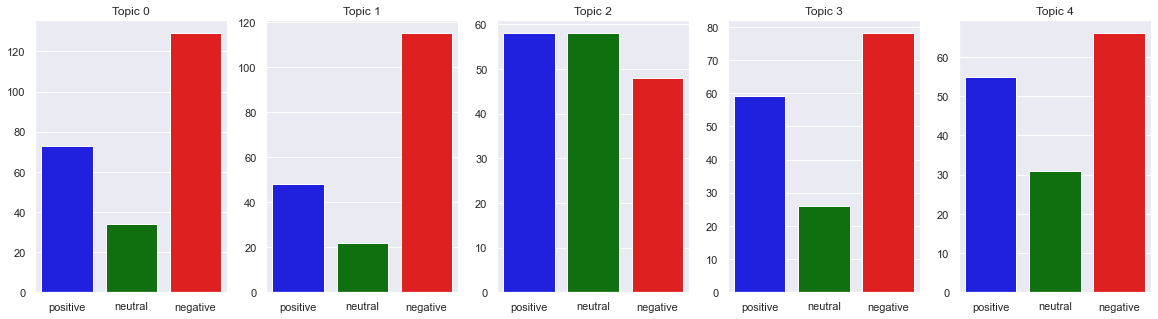

In [387]:
sns.set(rc={"figure.figsize":(20, 5)})
fig, axs = plt.subplots(ncols=5)
ax1 = sns.barplot(rus0.index, rus0.values, alpha=1, ax=axs[0], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax1.set_title("Topic 0")
ax2 = sns.barplot(rus1.index, rus1.values, alpha=1, ax=axs[1], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax2.set_title("Topic 1")
ax3 = sns.barplot(rus2.index, rus2.values, alpha=1, ax=axs[2], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax3.set_title("Topic 2")
ax4 = sns.barplot(rus3.index, rus3.values, alpha=1, ax=axs[3], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax4.set_title("Topic 3")
ax5 = sns.barplot(rus4.index, rus4.values, alpha=1, ax=axs[4], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax5.set_title("Topic 4")

#### Wordcloud (positive)

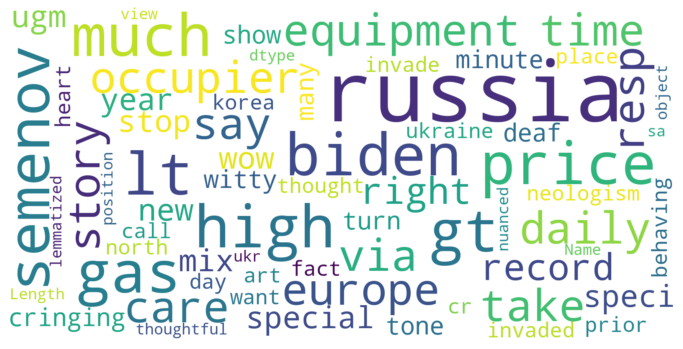

In [388]:
positive = tweet_rusdf.loc[tweet_rusdf['sentiment']=='positive', 'lemmatized']
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=500, background_color="white").generate(str(positive))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Wordcloud (negative)

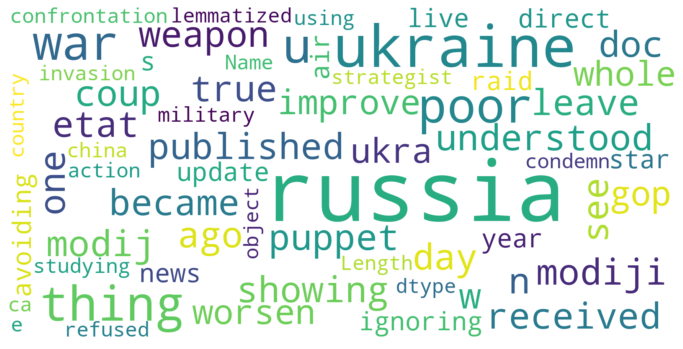

In [389]:
negative = tweet_rusdf.loc[tweet_rusdf['sentiment']=='negative', 'lemmatized']
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=500, background_color="white").generate(str(negative))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### #Ukraine

In [390]:
topic_model_lm2.visualize_barchart(top_n_topics = 5)

In [391]:
ukr0 = tweet_ukrdf[tweet_ukrdf['topics'] == 0]['sentiment'].value_counts()
ukr1 = tweet_ukrdf[tweet_ukrdf['topics'] == 1]['sentiment'].value_counts()
ukr2 = tweet_ukrdf[tweet_ukrdf['topics'] == 2]['sentiment'].value_counts()
ukr3 = tweet_ukrdf[tweet_ukrdf['topics'] == 3]['sentiment'].value_counts()
ukr4 = tweet_ukrdf[tweet_ukrdf['topics'] == 4]['sentiment'].value_counts()


Text(0.5, 1.0, 'Topic 4')

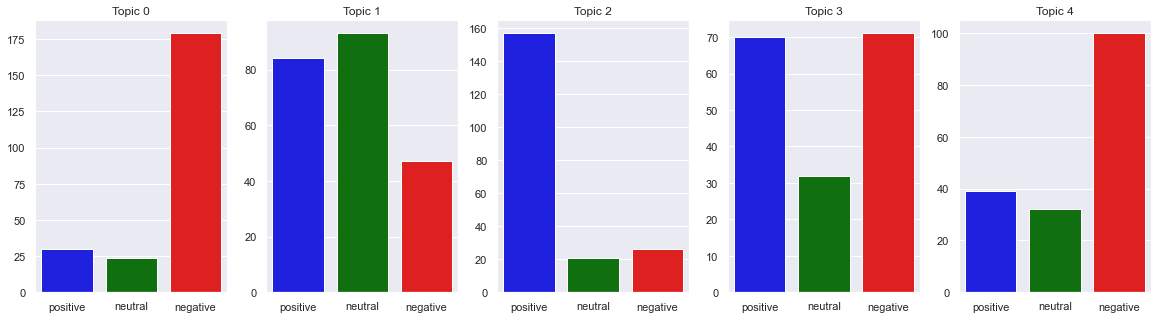

In [392]:
sns.set(rc={"figure.figsize":(20, 5)})
fig, axs = plt.subplots(ncols=5)
ax1 = sns.barplot(ukr0.index, ukr0.values, alpha=1, ax=axs[0], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax1.set_title("Topic 0")
ax2 = sns.barplot(ukr1.index, ukr1.values, alpha=1, ax=axs[1], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax2.set_title("Topic 1")
ax3 = sns.barplot(ukr2.index, ukr2.values, alpha=1, ax=axs[2], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax3.set_title("Topic 2")
ax4 = sns.barplot(ukr3.index, ukr3.values, alpha=1, ax=axs[3], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax4.set_title("Topic 3")
ax5 = sns.barplot(ukr4.index, ukr4.values, alpha=1, ax=axs[4], order=['positive', 'neutral', 'negative'], palette=['blue', 'green', 'red'])
ax5.set_title("Topic 4")

#### Wordcloud (positive)

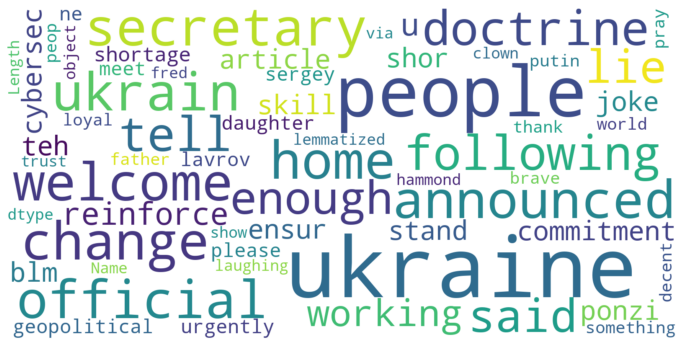

In [393]:
positive = tweet_ukrdf.loc[tweet_ukrdf['sentiment']=='positive', 'lemmatized']
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=500, background_color="white").generate(str(positive))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Wordcloud (negative)

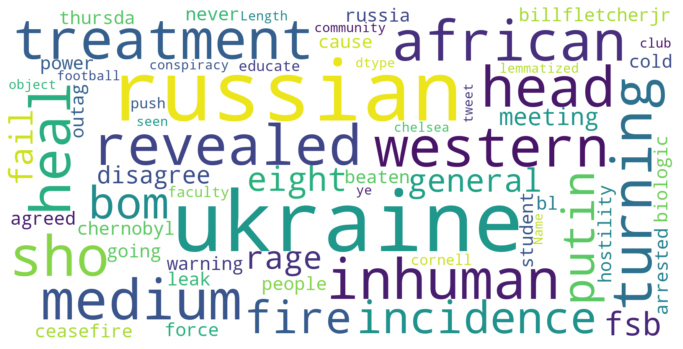

In [394]:
negative = tweet_ukrdf.loc[tweet_ukrdf['sentiment']=='negative', 'lemmatized']
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=500, background_color="white").generate(str(negative))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()